In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader

In [2]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(BATCH_SIZE, -1)
    
class Conv_Net(nn.Module):
    def __init__(self, seq, clf):
        super(Conv_Net, self).__init__()
        self.seq = seq
        self.clf = clf
        
    def forward(self, x):
        return self.clf(self.seq(x)) 

def build_new_net():
    #architecture of the network copied from the article
    seq = nn.Sequential(
        nn.Conv2d(1, 256, kernel_size=(7, 7), stride=(1, 1)),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1)),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1, ceil_mode=False),
        Flatten()
    )
    clf = nn.Linear(in_features=4608, out_features=10, bias=True)
    return seq, clf

In [3]:
#copied numbers from the article
N_EPOCHS = 80
Z_DIM = 2
STAT_STEP = 10
BATCH_SIZE = 1

device = 'cpu'

In [4]:
#read data
PATH = './Learned models/models_notMNIST/model_'
weights_paths = []
learned_models = []
for i in range(100):
    #reaally not effective
    seq, clf = build_new_net()
    model = Conv_Net(seq, clf)
    weights_paths.append(PATH + str(i) + '.pt')
    
    model.load_state_dict(torch.load(weights_paths[i], map_location = 'cpu'))
    learned_models.append(model)

In [5]:
weights = []
for model in learned_models:
    weights.append(model.seq)
    
print(weights[0])

Sequential(
  (0): Conv2d(1, 256, kernel_size=(7, 7), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
)


In [6]:
weights[0][0].weight.size()
for i in range(len(weights)):
    weights[i] = weights[i][0].weight
print(weights[0])

Parameter containing:
tensor([[[[-2.9268e-02, -4.3196e-02,  2.8730e-02,  ...,  3.1550e-02,
            2.6781e-03, -5.0364e-02],
          [ 3.0058e-02,  2.5196e-02,  4.3090e-02,  ..., -4.4220e-02,
           -4.8854e-02, -3.1027e-02],
          [ 2.8954e-02, -1.7861e-02, -6.7015e-04,  ...,  1.8797e-02,
            9.7225e-03, -9.4813e-04],
          ...,
          [ 3.0585e-04,  5.9464e-03,  3.1794e-02,  ..., -2.9756e-02,
            3.6758e-02, -5.5154e-02],
          [-6.0046e-04, -6.9832e-03, -4.6826e-03,  ...,  1.7021e-02,
           -2.3375e-04,  4.9559e-03],
          [-4.9226e-02, -2.1702e-02, -2.1248e-02,  ..., -3.6084e-02,
            3.1670e-02,  7.2641e-02]]],


        [[[ 1.1200e-04,  1.1580e-04,  1.5090e-04,  ...,  6.5184e-05,
           -3.2428e-04, -5.2981e-04],
          [ 8.7935e-05,  1.2855e-04,  1.2891e-04,  ..., -3.0532e-05,
           -8.9277e-04,  8.3260e-04],
          [ 8.8441e-05,  1.0115e-04,  6.3794e-05,  ..., -7.0753e-04,
            6.2061e-04,  1.8405e-0

In [7]:
train_loader = DataLoader(dataset=weights, batch_size=BATCH_SIZE, shuffle=True) 

In [8]:
#cuda!
#test on colab at least one iteration
class VAE(nn.Module):
    def __init__(self, d = Z_DIM):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
        #d - for latent space
        self.d = d
        
    def count_vlb(self, X):
        #get parameters of z distribution
        mu_z, var_z = self.encoder(X)

        #sample latent(mu_z, var_z)
        z = Normal(torch.zeros(mu_z.size()), torch.ones(mu_z.size())).sample()
        z = mu_z + torch.sqrt(var_z) * nn.Parameter(z, requires_grad=False)
              
        #get parameters of x_hat distribution
        mu_x, var_x = self.decoder(z)
                
        normal = Normal(mu_x, torch.sqrt(var_x))
        diagn = torch.distributions.Independent(normal, 1)
         
        #count loss
        latent_loss = torch.sum(var_x + mu_x**2 - 0.5 * torch.log(var_x) - 1)
        reconstruction_loss = diagn.log_prob(X)
        
        #coefs are to be chosen
        return -1*(torch.sum(reconstruction_loss) - torch.sum(latent_loss))
                   
    def generate_samples(self, num_samples):
        z = torch.cuda.FloatTensor(np.random.normal(0, 1, size=[num_samples, self.d]))
        return self.decoder(z)

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0)
        )
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        self.elu   = nn.ELU(alpha=1.0)
        
        self.fc_mu = nn.Conv2d(64, Z_DIM, kernel_size=(1, 1), stride=(1, 1))
        self.fc_var = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.ELU(alpha=1.0)
        )
        self.fc_mu = nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
        self.fc_var = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1)),
            nn.Softplus()
        )
        
    def forward(self, X):
        X = self.seq(X)
        mu = self.fc_mu(X)
        var = self.fc_var(X)
        
        return mu, var

In [11]:
#Adam optimizer with linear learning rate decay from 1e-3 to 0.
vae = VAE(Z_DIM)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay = 1e-3/N_EPOCHS)

In [12]:
loss_list = []
N_STEPS = len(train_loader)
print(N_STEPS)

#train network
for j in range(N_EPOCHS):
    for k, (images) in enumerate(train_loader):
        #forward
        images = images.view(images.size()[0]*images.size()[1], 1, 7, -1)
        images = images.to(device)
        vlb = vae.count_vlb(images)

        #backward
        optimizer.zero_grad()
        vlb.backward()
        optimizer.step()

        loss_list.append(vlb.item())
        
        if k % STAT_STEP == 0:
            print('Epoch {}/{}, Step {}/{}, Loss: {}'
                  .format(j, N_EPOCHS, k, N_STEPS, vlb.item()))

100
Epoch 0/80, Step 0/100, Loss: 8029.3876953125
Epoch 0/80, Step 10/100, Loss: 4824.38525390625
Epoch 0/80, Step 20/100, Loss: 1846.9866943359375
Epoch 0/80, Step 30/100, Loss: 1271.504638671875
Epoch 0/80, Step 40/100, Loss: 972.5849609375
Epoch 0/80, Step 50/100, Loss: 374.193359375
Epoch 0/80, Step 60/100, Loss: 209.93505859375
Epoch 0/80, Step 70/100, Loss: 67.41796875
Epoch 0/80, Step 80/100, Loss: 37.42578125
Epoch 0/80, Step 90/100, Loss: -12.8486328125
Epoch 1/80, Step 0/100, Loss: -21.916015625
Epoch 1/80, Step 10/100, Loss: -22.857421875
Epoch 1/80, Step 20/100, Loss: -51.4560546875
Epoch 1/80, Step 30/100, Loss: -50.787109375
Epoch 1/80, Step 40/100, Loss: -73.361328125
Epoch 1/80, Step 50/100, Loss: -82.310546875
Epoch 1/80, Step 60/100, Loss: -73.501953125
Epoch 1/80, Step 70/100, Loss: -57.7666015625
Epoch 1/80, Step 80/100, Loss: -84.859375
Epoch 1/80, Step 90/100, Loss: -79.3203125
Epoch 2/80, Step 0/100, Loss: -91.5400390625
Epoch 2/80, Step 10/100, Loss: -86.7851562

Epoch 17/80, Step 80/100, Loss: -216.501953125
Epoch 17/80, Step 90/100, Loss: -202.892578125
Epoch 18/80, Step 0/100, Loss: -232.56640625
Epoch 18/80, Step 10/100, Loss: -229.08203125
Epoch 18/80, Step 20/100, Loss: -206.921875
Epoch 18/80, Step 30/100, Loss: -214.0439453125
Epoch 18/80, Step 40/100, Loss: -221.0654296875
Epoch 18/80, Step 50/100, Loss: -203.1142578125
Epoch 18/80, Step 60/100, Loss: -203.6484375
Epoch 18/80, Step 70/100, Loss: -215.6103515625
Epoch 18/80, Step 80/100, Loss: -223.1259765625
Epoch 18/80, Step 90/100, Loss: -211.5927734375
Epoch 19/80, Step 0/100, Loss: -220.716796875
Epoch 19/80, Step 10/100, Loss: -209.0107421875
Epoch 19/80, Step 20/100, Loss: -225.0283203125
Epoch 19/80, Step 30/100, Loss: -214.802734375
Epoch 19/80, Step 40/100, Loss: -213.552734375
Epoch 19/80, Step 50/100, Loss: -214.9169921875
Epoch 19/80, Step 60/100, Loss: -218.1796875
Epoch 19/80, Step 70/100, Loss: -197.12890625
Epoch 19/80, Step 80/100, Loss: -218.6025390625
Epoch 19/80, St

Epoch 35/80, Step 30/100, Loss: -267.302734375
Epoch 35/80, Step 40/100, Loss: -250.54296875
Epoch 35/80, Step 50/100, Loss: -242.712890625
Epoch 35/80, Step 60/100, Loss: -251.2626953125
Epoch 35/80, Step 70/100, Loss: -258.2578125
Epoch 35/80, Step 80/100, Loss: -229.5244140625
Epoch 35/80, Step 90/100, Loss: -250.923828125
Epoch 36/80, Step 0/100, Loss: -254.3125
Epoch 36/80, Step 10/100, Loss: -220.173828125
Epoch 36/80, Step 20/100, Loss: -284.2841796875
Epoch 36/80, Step 30/100, Loss: -253.3193359375
Epoch 36/80, Step 40/100, Loss: -239.0322265625
Epoch 36/80, Step 50/100, Loss: -267.953125
Epoch 36/80, Step 60/100, Loss: -254.5478515625
Epoch 36/80, Step 70/100, Loss: -275.4912109375
Epoch 36/80, Step 80/100, Loss: -262.4736328125
Epoch 36/80, Step 90/100, Loss: -275.0302734375
Epoch 37/80, Step 0/100, Loss: -264.380859375
Epoch 37/80, Step 10/100, Loss: -239.4619140625
Epoch 37/80, Step 20/100, Loss: -221.26953125
Epoch 37/80, Step 30/100, Loss: -239.455078125
Epoch 37/80, Step

Epoch 52/80, Step 80/100, Loss: -293.78125
Epoch 52/80, Step 90/100, Loss: -310.1513671875
Epoch 53/80, Step 0/100, Loss: -268.919921875
Epoch 53/80, Step 10/100, Loss: -286.626953125
Epoch 53/80, Step 20/100, Loss: -296.658203125
Epoch 53/80, Step 30/100, Loss: -300.7626953125
Epoch 53/80, Step 40/100, Loss: -250.7314453125
Epoch 53/80, Step 50/100, Loss: -296.3720703125
Epoch 53/80, Step 60/100, Loss: -295.6875
Epoch 53/80, Step 70/100, Loss: -293.4384765625
Epoch 53/80, Step 80/100, Loss: -279.0283203125
Epoch 53/80, Step 90/100, Loss: -322.8134765625
Epoch 54/80, Step 0/100, Loss: -306.955078125
Epoch 54/80, Step 10/100, Loss: -279.6494140625
Epoch 54/80, Step 20/100, Loss: -268.7919921875
Epoch 54/80, Step 30/100, Loss: -301.5712890625
Epoch 54/80, Step 40/100, Loss: -289.794921875
Epoch 54/80, Step 50/100, Loss: -304.6748046875
Epoch 54/80, Step 60/100, Loss: -295.6875
Epoch 54/80, Step 70/100, Loss: -310.3935546875
Epoch 54/80, Step 80/100, Loss: -307.994140625
Epoch 54/80, Step

Epoch 70/80, Step 30/100, Loss: -324.33203125
Epoch 70/80, Step 40/100, Loss: -340.9453125
Epoch 70/80, Step 50/100, Loss: -335.078125
Epoch 70/80, Step 60/100, Loss: -331.919921875
Epoch 70/80, Step 70/100, Loss: -292.943359375
Epoch 70/80, Step 80/100, Loss: -320.6669921875
Epoch 70/80, Step 90/100, Loss: -325.4150390625
Epoch 71/80, Step 0/100, Loss: -352.8193359375
Epoch 71/80, Step 10/100, Loss: -306.0068359375
Epoch 71/80, Step 20/100, Loss: -315.5830078125
Epoch 71/80, Step 30/100, Loss: -346.29296875
Epoch 71/80, Step 40/100, Loss: -308.185546875
Epoch 71/80, Step 50/100, Loss: -333.0986328125
Epoch 71/80, Step 60/100, Loss: -347.9052734375
Epoch 71/80, Step 70/100, Loss: -321.126953125
Epoch 71/80, Step 80/100, Loss: -335.193359375
Epoch 71/80, Step 90/100, Loss: -325.9072265625
Epoch 72/80, Step 0/100, Loss: -302.0693359375
Epoch 72/80, Step 10/100, Loss: -350.37109375
Epoch 72/80, Step 20/100, Loss: -350.009765625
Epoch 72/80, Step 30/100, Loss: -299.2705078125
Epoch 72/80, 

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([i for i in range(len(loss_list))], loss_list)

plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

<Figure size 640x480 with 1 Axes>

In [14]:
torch.save(vae.state_dict(), "vae_mnist.pth")

(25600,)


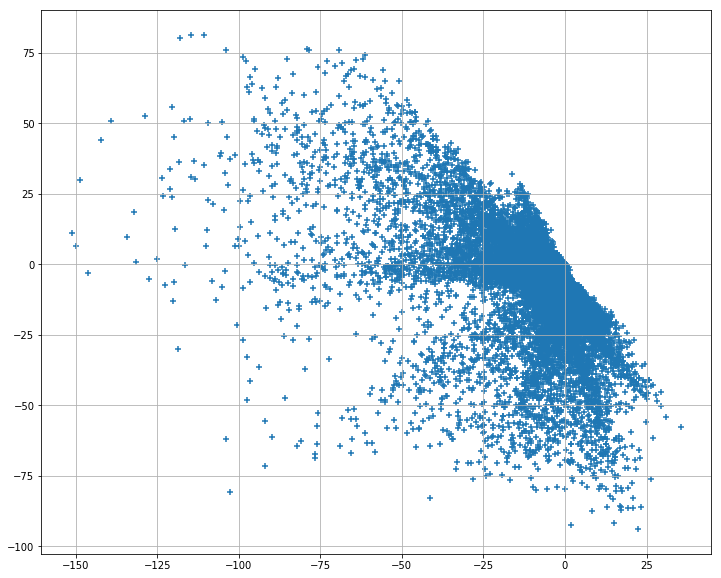

In [36]:
vae.load_state_dict(torch.load("vae_mnist.pth"))

mu_list = []

with torch.no_grad():
    for k, images in enumerate(train_loader):
        images = images.view(images.size()[0]*images.size()[1], 1, 7, -1)
        images = images.to(device)
        mu, var  = vae.encoder(images)
        mu = mu.cpu().numpy()
        mu_list.append(mu)

mu = np.concatenate(mu_list)
mu = np.squeeze(mu, axis = 2)
mu = np.squeeze(mu, axis = 2)

print(mu[:, 0].shape)

plt.figure(figsize=(12, 10))

plt.scatter(mu[:, 0], mu[:, 1], marker = '+')

plt.grid()
    

In [16]:
mu = torch.eye(3, 3)*10
mu[0, 1] = 2
mu[0, 2] = 10
mu[1, 0] = 3
mu[1, 2] = -1
mu[2, 0] = 1
mu[2, 1] = -10
mu = mu
print(mu)
sigma = torch.eye(3, 3)*2
sigma[0, 1] = 2
sigma[0, 2] = 10
sigma[1, 0] = 3
sigma[1, 2] = 100
sigma[2, 0] = 1
sigma[2, 1] = 10
print(sigma)
K = 1

tensor([[ 10.,   2.,  10.],
        [  3.,  10.,  -1.],
        [  1., -10.,  10.]])
tensor([[  2.,   2.,  10.],
        [  3.,   2., 100.],
        [  1.,  10.,   2.]])


In [17]:
std_z = torch.from_numpy(np.random.normal(0, 1, size=[*sigma.size(), K])).type(mu.type())
std_z = std_z.permute(0, 2, 1)
z = mu[:, None, :] + torch.sqrt(sigma[:, None, :]) * nn.Parameter(std_z, requires_grad=False)
print(z)
print(z.mean())
print(z.std())

z = Normal(torch.zeros(3, 3), torch.ones(3, 3)).sample()
z = mu + torch.sqrt(sigma) * z
print(z)
print(z.mean())
print(z.std())

tensor([[[  7.8985,   4.0658,   9.2987]],

        [[  2.8061,   9.3395, -10.4923]],

        [[  0.5264,  -4.4855,  10.0234]]])
tensor(3.2201)
tensor(7.0544)
tensor([[ 10.5325,   1.5255,   6.5950],
        [  1.3136,   9.9793,   2.6235],
        [ -0.2273, -11.6868,   8.3865]])
tensor(3.2269)
tensor(6.8757)
